In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

dir = '/content/drive/MyDrive/VSEM Projects/DL Project/dataset'
sub_dirs = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]

In [ ]:
data = {
    'name':[],
    'dest':[]
}
for name in sub_dirs:
  files = [f for f in os.listdir(dir+'/'+name) if os.path.isfile(os.path.join(dir+'/'+name, f))]
  for file_ in files:
    data['name'].append(name)
    data['dest'].append(name+'/'+file_)

In [ ]:
import pandas

df = pandas.DataFrame(data)
df.head()

,name,dest
0,Vladimir_Putin,Vladimir_Putin/Vladimir_Putin_0017.jpg
1,Vladimir_Putin,Vladimir_Putin/Vladimir_Putin_0027.jpg
2,Vladimir_Putin,Vladimir_Putin/Vladimir_Putin_0034.jpg
3,Vladimir_Putin,Vladimir_Putin/Vladimir_Putin_0024.jpg
4,Vladimir_Putin,Vladimir_Putin/Vladimir_Putin_0015.jpg


In [ ]:
import cv2
from tqdm import tqdm

images = []

for image_filename in tqdm(list(df['dest'])):
  image_path = os.path.join(dir, image_filename)
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = cv2.resize(image, (128, 128))
  images.append(image)

In [ ]:
import pickle
import pandas
import numpy

file = open('/content/drive/MyDrive/VSEM Projects/DL Project/images3.pkl', 'rb')
images = pickle.load(file)
df = pandas.read_csv("/content/drive/MyDrive/VSEM Projects/DL Project/df.csv")
grouped = df.groupby('name', sort=False)
indexes = []
for i, (name, group) in enumerate(grouped):
  if i > 50:
    break
  for x in group.head(10).index.values:
    indexes.append(x)
X = numpy.array([images[i] for i in indexes])
y = numpy.array(list(df.loc[indexes]['name']))

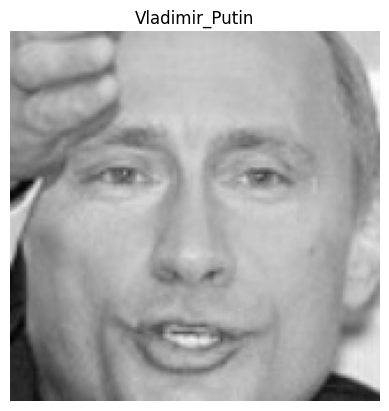

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = X[1]
plt.imshow(img)
plt.title(y[1])
plt.axis('off')
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.imagenet_utils import preprocess_input

target_size = (224, 224)
resized_images = []
for img in X:
    resized_img = image.array_to_img(img, scale=False)
    resized_img = resized_img.resize(target_size)
    resized_img = image.img_to_array(resized_img)
    resized_images.append(resized_img)

resized_images = np.array(resized_images)

if resized_images.shape[3] == 1:
    resized_images = np.concatenate([resized_images] * 3, axis=-1)

X = preprocess_input(resized_images)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

In [ ]:
from tensorflow import keras

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)


num_classes = len(label_encoder.classes_)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

In [ ]:
del(X, y)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

alexnet_model = Sequential()

alexnet_model.add(Conv2D(96, (11, 11), strides=(4, 4), input_shape=(224, 224, 3), activation='relu', kernel_regularizer=l2(0.0005)))
alexnet_model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

alexnet_model.add(Conv2D(256, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.0005)))
alexnet_model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

alexnet_model.add(Conv2D(384, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0005)))
alexnet_model.add(Conv2D(384, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0005)))

alexnet_model.add(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0005)))
alexnet_model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

alexnet_model.add(Flatten())

alexnet_model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.0005)))
alexnet_model.add(Dropout(0.5))

alexnet_model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.0005)))
alexnet_model.add(Dropout(0.5))

alexnet_model.add(Dense(num_classes, activation='softmax'))

alexnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 384)       1

Epoch 1/50
10/10 [==============================] - 18s 189ms/step - loss: 12.3700 - accuracy: 0.0131 - val_loss: 8.9653 - val_accuracy: 0.0196
Epoch 2/50
10/10 [==============================] - 1s 53ms/step - loss: 9.0506 - accuracy: 0.0294 - val_loss: 8.8730 - val_accuracy: 0.0392
Epoch 3/50
10/10 [==============================] - 1s 61ms/step - loss: 8.9300 - accuracy: 0.0261 - val_loss: 8.8225 - val_accuracy: 0.0294
Epoch 4/50
10/10 [==============================] - 1s 61ms/step - loss: 8.7820 - accuracy: 0.0359 - val_loss: 8.7561 - val_accuracy: 0.0294
Epoch 5/50
10/10 [==============================] - 1s 54ms/step - loss: 8.7138 - accuracy: 0.0392 - val_loss: 8.6927 - val_accuracy: 0.0196
Epoch 6/50
10/10 [==============================] - 1s 61ms/step - loss: 8.6235 - accuracy: 0.0588 - val_loss: 8.6294 - val_accuracy: 0.0490
Epoch 7/50
10/10 [==============================] - 1s 54ms/step - loss: 8.5188 - accuracy: 0.0686 - val_loss: 8.5163 - val_accuracy: 0.0882
Epoch 8/50

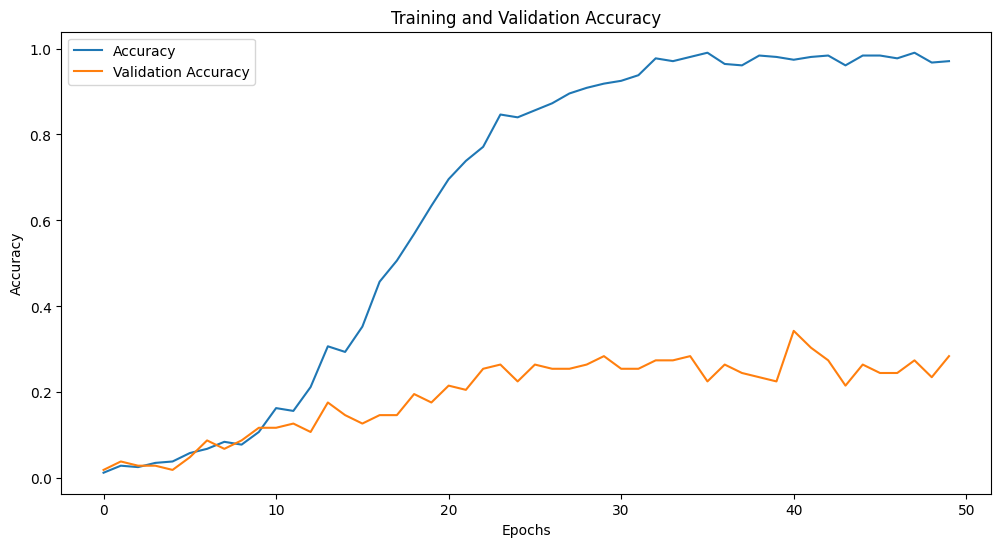

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=10000, decay_rate=0.9)
optimizer = Adam(learning_rate=lr_schedule)

alexnet_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = alexnet_model.fit(X_train, y_train, epochs=50, batch_size=32,  validation_data=(X_val, y_val))

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
predictions = alexnet_model.predict(X_test)
import numpy as np
predicted_identity = np.argmax(predictions, axis=1)

4/4 [==============================] - 0s 19ms/step


In [ ]:
ytest = np.argmax(y_test, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(ytest, predicted_identity)
print(f'Accuracy: {accuracy}')

Accuracy: 0.2549019607843137


In [ ]:
from tensorflow.keras.layers import Activation

model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())

model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.0005)))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.0005)))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_8 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                 

Epoch 1/50
10/10 [==============================] - 34s 2s/step - loss: 11.3518 - accuracy: 0.0196 - val_loss: 11.0868 - val_accuracy: 0.0196
Epoch 2/50
10/10 [==============================] - 5s 501ms/step - loss: 10.9433 - accuracy: 0.0065 - val_loss: 10.7484 - val_accuracy: 0.0294
Epoch 3/50
10/10 [==============================] - 5s 497ms/step - loss: 10.6111 - accuracy: 0.0033 - val_loss: 10.4192 - val_accuracy: 0.0196
Epoch 4/50
10/10 [==============================] - 5s 471ms/step - loss: 10.2829 - accuracy: 0.0196 - val_loss: 10.1062 - val_accuracy: 0.0196
Epoch 5/50
10/10 [==============================] - 5s 475ms/step - loss: 9.9772 - accuracy: 0.0065 - val_loss: 9.8102 - val_accuracy: 0.0196
Epoch 6/50
10/10 [==============================] - 5s 467ms/step - loss: 9.6890 - accuracy: 0.0261 - val_loss: 9.5258 - val_accuracy: 0.0196
Epoch 7/50
10/10 [==============================] - 5s 466ms/step - loss: 9.4329 - accuracy: 0.0229 - val_loss: 9.2818 - val_accuracy: 0.0294


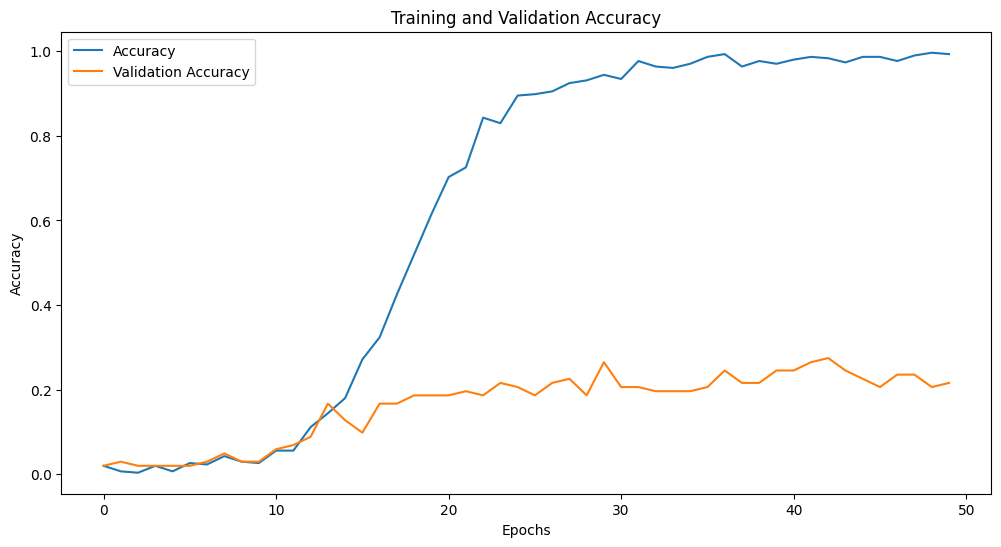

In [ ]:
initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=10000, decay_rate=0.9)  # Adjust decay_steps and decay_rate as needed
optimizer = Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32,  validation_data=(X_val, y_val))

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(X_test)
predicted_identity = np.argmax(predictions, axis=1)
ytest = np.argmax(y_test, axis=1)

4/4 [==============================] - 1s 137ms/step


In [ ]:
accuracy = accuracy_score(ytest, predicted_identity)
print(f'Accuracy: {accuracy}')

Accuracy: 0.21568627450980393


In [ ]:
file = open('/content/drive/MyDrive/VSEM Projects/DL Project/images4.pkl', 'rb')
images = pickle.load(file)
df = pandas.read_csv("/content/drive/MyDrive/VSEM Projects/DL Project/df2.csv")
grouped = df.groupby('name', sort=False)
indexes = []
for i, (name, group) in enumerate(grouped):
  if i > 50:
    break
  for x in group.head(10).index.values:
    indexes.append(x)
X = numpy.array([images[i] for i in indexes])
y = numpy.array(list(df.loc[indexes]['name']))

In [ ]:
X.shape

(400, 160, 160, 3)

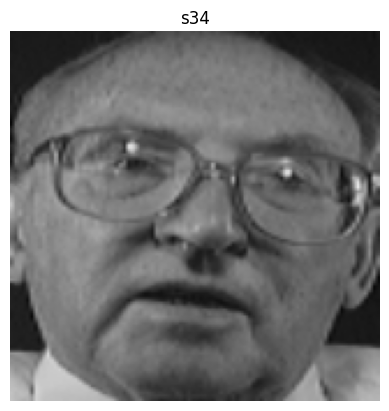

In [ ]:
img = X[1]
plt.imshow(img)
plt.title(y[1])
plt.axis('off')
plt.show()

In [ ]:
target_size = (224, 224)
resized_images = []
for img in X:
    resized_img = image.array_to_img(img, scale=False)
    resized_img = resized_img.resize(target_size)
    resized_img = image.img_to_array(resized_img)
    resized_images.append(resized_img)

resized_images = np.array(resized_images)

if resized_images.shape[3] == 1:
    resized_images = np.concatenate([resized_images] * 3, axis=-1)

X = preprocess_input(resized_images)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)


In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

num_classes = len(label_encoder.classes_)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

In [ ]:
del(X, y)

In [ ]:
alexnet_model = Sequential()

alexnet_model.add(Conv2D(96, (11, 11), strides=(4, 4), input_shape=(224, 224, 3), activation='relu', kernel_regularizer=l2(0.0005)))
alexnet_model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

alexnet_model.add(Conv2D(256, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.0005)))
alexnet_model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

alexnet_model.add(Conv2D(384, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0005)))
alexnet_model.add(Conv2D(384, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0005)))

alexnet_model.add(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0005)))
alexnet_model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

alexnet_model.add(Flatten())

alexnet_model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.0005)))
alexnet_model.add(Dropout(0.5))

alexnet_model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.0005)))
alexnet_model.add(Dropout(0.5))

alexnet_model.add(Dense(num_classes, activation='softmax'))

alexnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 26, 26, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 12, 12, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 12, 12, 384)       885120    
                                                                 
 conv2d_21 (Conv2D)          (None, 12, 12, 384)      

Epoch 1/50
8/8 [==============================] - 6s 205ms/step - loss: 11.8297 - accuracy: 0.0500 - val_loss: 8.7306 - val_accuracy: 0.0625
Epoch 2/50
8/8 [==============================] - 0s 52ms/step - loss: 8.8723 - accuracy: 0.0250 - val_loss: 8.5633 - val_accuracy: 0.1125
Epoch 3/50
8/8 [==============================] - 0s 53ms/step - loss: 8.5970 - accuracy: 0.0250 - val_loss: 8.4555 - val_accuracy: 0.1375
Epoch 4/50
8/8 [==============================] - 0s 55ms/step - loss: 8.4723 - accuracy: 0.0708 - val_loss: 8.2919 - val_accuracy: 0.1500
Epoch 5/50
8/8 [==============================] - 0s 52ms/step - loss: 8.2908 - accuracy: 0.0875 - val_loss: 7.9708 - val_accuracy: 0.2625
Epoch 6/50
8/8 [==============================] - 0s 53ms/step - loss: 7.9833 - accuracy: 0.1542 - val_loss: 7.6011 - val_accuracy: 0.3750
Epoch 7/50
8/8 [==============================] - 0s 54ms/step - loss: 7.6077 - accuracy: 0.2042 - val_loss: 7.1356 - val_accuracy: 0.4750
Epoch 8/50
8/8 [=========

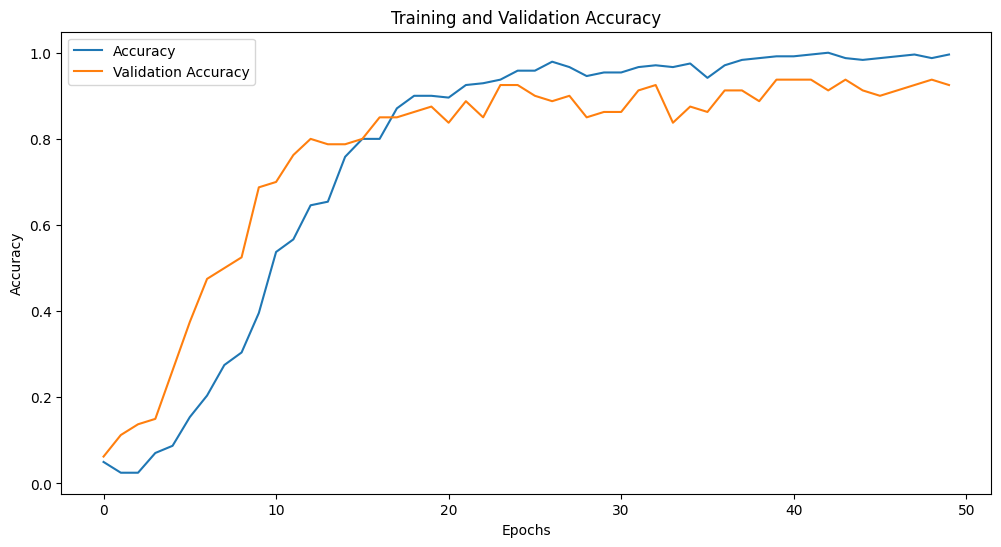

In [ ]:
initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=10000, decay_rate=0.9)  # Adjust decay_steps and decay_rate as needed
optimizer = Adam(learning_rate=lr_schedule)

alexnet_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = alexnet_model.fit(X_train, y_train, epochs=50, batch_size=32,  validation_data=(X_val, y_val))

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
predictions = alexnet_model.predict(X_test)
predicted_identity = np.argmax(predictions, axis=1)

3/3 [==============================] - 1s 21ms/step


In [ ]:
ytest = np.argmax(y_test, axis=1)

In [ ]:
accuracy = accuracy_score(ytest, predicted_identity)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9375


In [ ]:
model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())

model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.0005)))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.0005)))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_24 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 112, 112, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_26 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 56, 56, 128)       0         
 ng2D)                                                

Epoch 1/50
8/8 [==============================] - 17s 1s/step - loss: 11.1372 - accuracy: 0.0167 - val_loss: 10.8824 - val_accuracy: 0.0250
Epoch 2/50
8/8 [==============================] - 4s 463ms/step - loss: 10.7603 - accuracy: 0.0250 - val_loss: 10.5861 - val_accuracy: 0.0500
Epoch 3/50
8/8 [==============================] - 4s 502ms/step - loss: 10.4803 - accuracy: 0.0208 - val_loss: 10.2998 - val_accuracy: 0.0250
Epoch 4/50
8/8 [==============================] - 4s 460ms/step - loss: 10.1977 - accuracy: 0.0125 - val_loss: 10.0317 - val_accuracy: 0.0375
Epoch 5/50
8/8 [==============================] - 4s 469ms/step - loss: 9.9251 - accuracy: 0.0333 - val_loss: 9.7551 - val_accuracy: 0.0750
Epoch 6/50
8/8 [==============================] - 4s 513ms/step - loss: 9.6559 - accuracy: 0.0375 - val_loss: 9.4700 - val_accuracy: 0.0875
Epoch 7/50
8/8 [==============================] - 4s 459ms/step - loss: 9.3567 - accuracy: 0.0417 - val_loss: 9.2052 - val_accuracy: 0.1375
Epoch 8/50
8/8

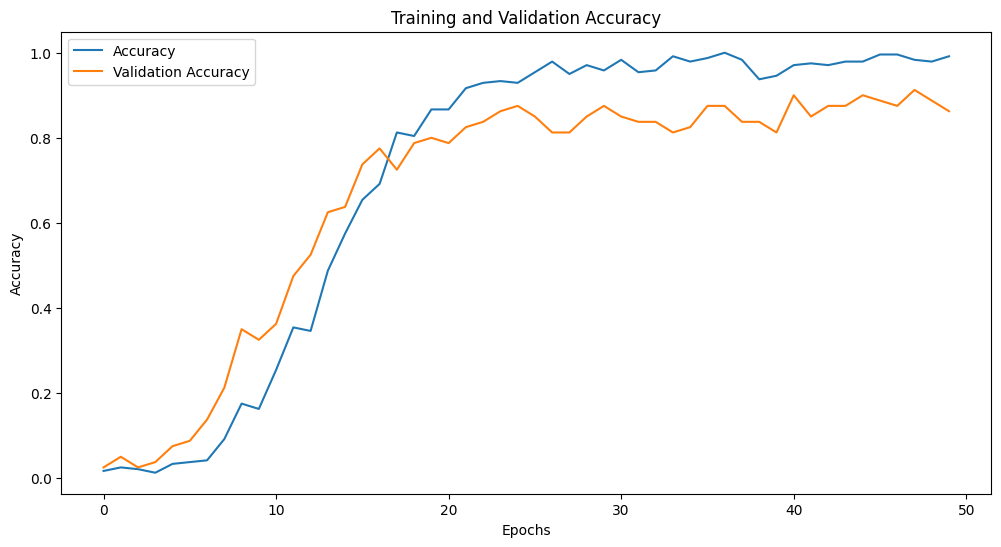

In [ ]:
initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=10000, decay_rate=0.9)  # Adjust decay_steps and decay_rate as needed
optimizer = Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32,  validation_data=(X_val, y_val))

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(X_test)
predicted_identity = np.argmax(predictions, axis=1)
ytest = np.argmax(y_test, axis=1)

3/3 [==============================] - 0s 157ms/step


In [ ]:
accuracy = accuracy_score(ytest, predicted_identity)
print(f'Accuracy: {accuracy}')

Accuracy: 0.775


In [ ]:
alexnet_model.save('/content/drive/MyDrive/VSEM Projects/DL Project/model.keras')